## Clean and Transform Captcha Images into a Pixel-Based Dataset

I list the files in the input and output directories to confirm that the expected .txt image files and any processed outputs are available. Basic error handling is included to catch issues like missing folders or access errors.

In [1]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

input_folder_path = '/content/drive/My Drive/sampleCaptchas/input'
output_folder_path = '/content/drive/My Drive/sampleCaptchas/output'

# List files in the input folder
print("Files in input folder:")
try:
    input_files = os.listdir(input_folder_path)
    for file in input_files:
        print(file)
except FileNotFoundError:
    print(f"Input folder not found at: {input_folder_path}")
except OSError as e:
    print(f"OSError accessing input folder: {e}")


print("\nFiles in output folder:")

# List files in the output folder
try:
    output_files = os.listdir(output_folder_path)
    for file in output_files:
        print(file)
except FileNotFoundError:
    print(f"Output folder not found at: {output_folder_path}")
except OSError as e:
    print(f"OSError accessing output folder: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in input folder:
input07.jpg
input05.jpg
input02.jpg
input00.jpg
input01.jpg
input06.jpg
input04.jpg
input03.jpg
input10.jpg
input08.jpg
input11.jpg
input16.jpg
input13.jpg
input14.jpg
input12.jpg
input17.jpg
input15.jpg
input18.jpg
input19.jpg
input21.jpg
input22.jpg
input20.jpg
input23.jpg
input24.jpg
input100.jpg
input01.txt
input00.txt
input02.txt
input03.txt
input04.txt
input05.txt
input07.txt
input06.txt
input09.txt
input08.txt
input10.txt
input11.txt
input12.txt
input13.txt
input14.txt
input15.txt
input16.txt
input17.txt
input18.txt
input19.txt
input20.txt
input21.txt
input22.txt
input23.txt
input24.txt
input09.jpg

Files in output folder:
output19.txt
output06.txt
output13.txt
output15.txt
output22.txt
output03.txt
output10.txt
output01.txt
output04.txt
output12.txt
output16.txt
output09.txt
output07.txt
output11.txt
output20.txt
output17.txt
ou

 I load a sample CAPTCHA image (input24.jpg) using OpenCV, which reads images in BGR format by default. To display the image correctly using Matplotlib, I convert it to RGB format. This visualization helps to inspect the image layout and character spacing before manual segmentation.

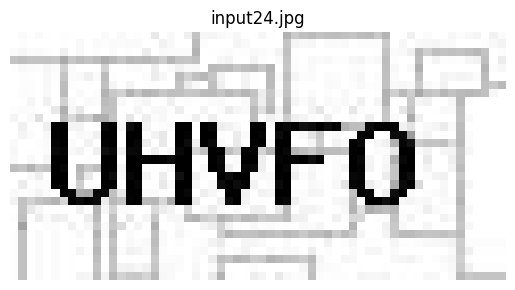

In [2]:
import cv2
import matplotlib.pyplot as plt

# Load image using OpenCV
img = cv2.imread("/content/drive/My Drive/sampleCaptchas/input/input24.jpg")

# Convert to RGB for correct color display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(img_rgb)
plt.axis('off')
plt.title("input24.jpg")
plt.show()


This code loads and visualizes an image stored in a .txt file, where each line represents pixel RGB values. It reconstructs the image by reading its dimensions and pixel data, then displays it using matplotlib. This step helps verify that the .txt file correctly represents the image and aligns with the original image file.

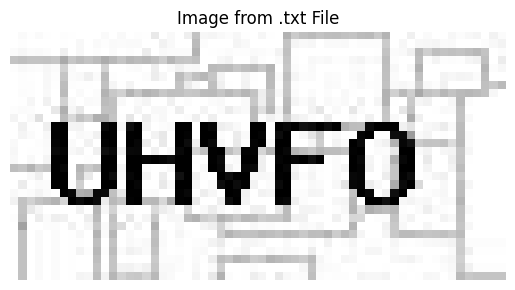

In [3]:
import numpy as np
import ast
import cv2
import matplotlib.pyplot as plt

def load_txt_image(txt_path):
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    # First line: height and width
    height, width = map(int, lines[0].strip().split())

    pixels = []
    for line in lines[1:]:
        row = []
        for pixel_str in line.strip().split():
            r, g, b = map(int, pixel_str.split(','))
            row.append([r, g, b])
        pixels.append(row)

    # Convert to numpy array
    img_array = np.array(pixels, dtype=np.uint8)
    return img_array

# Example usage
txt_path = "/content/drive/My Drive/sampleCaptchas/input/input24.txt"
img_array = load_txt_image(txt_path)

# Show the image
plt.imshow(img_array)
plt.axis('off')
plt.title("Image from .txt File")
plt.show()


This code segments the CAPTCHA image into individual character regions using manually specified x-coordinate ranges. By visualizing these segments, I can iteratively test and adjust the coordinates to find the optimal boundaries that correctly isolate each character. This manual tuning ensures consistent character sizing and positioning for further processing and model training.

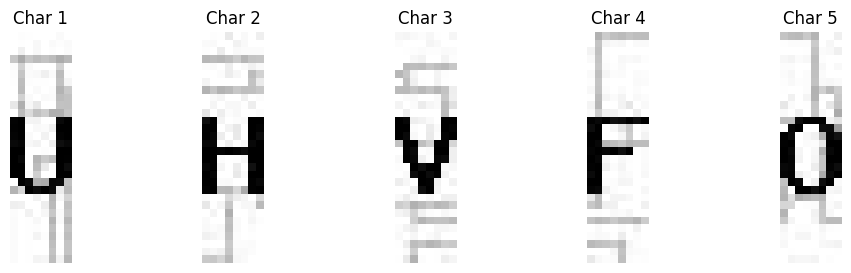

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def load_txt_image(txt_path):
    with open(txt_path, 'r') as f:
        lines = f.readlines()

    height, width = map(int, lines[0].strip().split())
    pixels = []
    for line in lines[1:]:
        row = []
        for pixel_str in line.strip().split():
            r, g, b = map(int, pixel_str.split(','))
            row.append([r, g, b])
        pixels.append(row)
    img_array = np.array(pixels, dtype=np.uint8)
    return img_array

def manual_segment(img, x_coords):
    segments = []
    for (x1, x2) in x_coords:
        segment = img[:, x1:x2]
        segments.append(segment)
    return segments

def plot_segments(segments):
    plt.figure(figsize=(12,3))
    for i, seg in enumerate(segments):
        plt.subplot(1, len(segments), i+1)
        plt.imshow(seg)
        plt.axis('off')
        plt.title(f"Char {i+1}")
    plt.show()


txt_path = "/content/drive/My Drive/sampleCaptchas/input/input24.txt"
img = load_txt_image(txt_path)

# Manually set x-coordinates for the 5 characters (adjust after visual inspection)
x_coords = [
    (5, 13),
    (14, 22),
    (23, 31),
    (32, 40),
    (41, 49)
]

segments = manual_segment(img, x_coords)
plot_segments(segments)


This code loads the CAPTCHA image from a .txt file, segments it into individual characters based on specified x-coordinate ranges, and applies a cleaning function to remove grayish background lines. The parameters gray_thresh=50 and intensity_range=(50, 260) were manually tuned to effectively identify and mask out the gray pixels, which helps reduce noise and improves character clarity for better downstream processing. The resulting cleaned character segments are then visualized for verification.

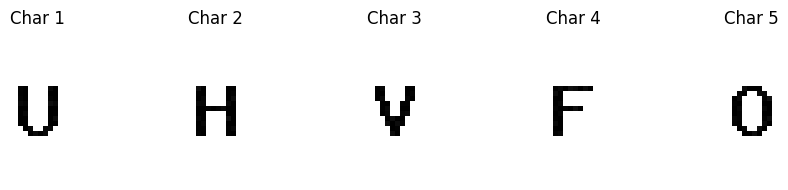

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Path to test input txt
txt_path = "/content/drive/My Drive/sampleCaptchas/input/input24.txt"
output_dir = "/content/drive/My Drive/sampleCaptchas/test_output"
base_filename = "input24"

# Load the RGB image from .txt
def load_image_from_txt(txt_path):
    with open(txt_path, "r") as f:
        lines = f.readlines()
    height, width = map(int, lines[0].split())
    img = np.zeros((height, width, 3), dtype=np.uint8)
    for i, line in enumerate(lines[1:]):
        pixels = line.strip().split()
        for j, pix in enumerate(pixels):
            r, g, b = map(int, pix.split(","))
            img[i, j] = [r, g, b]
    return img

# Define the segmentation coordinates
x_coords = [
    (5, 13),
    (14, 22),
    (23, 31),
    (32, 40),
    (41, 49)
]

# Segment and clean
def segment_image(img, x_coords):
    segments = [img[:, x1:x2] for x1, x2 in x_coords]
    return segments

# Reuse from before
def clean_greylines(segment, gray_thresh=50, intensity_range=(50, 260)):
    cleaned = segment.copy()

    r = cleaned[:, :, 0]
    g = cleaned[:, :, 1]
    b = cleaned[:, :, 2]

    # Conditions for gray detection
    gray_mask = (
        (np.abs(r - g) < gray_thresh) &
        (np.abs(g - b) < gray_thresh) &
        (r >= intensity_range[0]) & (r <= intensity_range[1]) &
        (g >= intensity_range[0]) & (g <= intensity_range[1]) &
        (b >= intensity_range[0]) & (b <= intensity_range[1])
    )

    # Apply mask to set those pixels to white
    cleaned[gray_mask] = [255, 255, 255]
    return cleaned

# Load, segment, clean and show
img = load_image_from_txt(txt_path)
segments = segment_image(img, x_coords)
cleaned_segments = [clean_greylines(seg) for seg in segments]

# Visualize
plt.figure(figsize=(10, 2))
for idx, seg in enumerate(cleaned_segments):
    plt.subplot(1, 5, idx + 1)
    plt.imshow(seg)
    plt.title(f"Char {idx+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()


The code below defines a pipeline to build a labeled dataset from raw CAPTCHA images stored as .txt files.

1. **Image Loading**: The function load_txt_image reads each .txt file, which contains RGB pixel values for a CAPTCHA image, and converts it into a 3D NumPy array representing the image.

2. **Segmentation**: The manual_segment function slices the full image horizontally into individual character segments based on predefined x-coordinate ranges (x_coords). Each segment ideally corresponds to one character.

3. **Cleaning**: Each character segment is processed by clean_greylines, which removes grayish background lines that often interfere with character recognition. This is done by masking pixels with similar RGB values within a threshold (gray_thresh) and intensity range, replacing them with white pixels.

4. **Label Extraction**: The extract_label function reads the ground-truth label corresponding to each CAPTCHA image from a matching text file in the label_folder.

5. **Dataset Construction**: The build_dataset function iterates through all input .txt image files, segments and cleans them, and pairs each character segment with its label. The character images are flattened into feature vectors. It skips any files where the number of segments doesn't match the label length, ensuring data integrity.

6. **Saving Dataset**: Finally, the feature vectors and their labels are combined into a DataFrame, expanded into individual pixel columns, and saved as a CSV file (captcha_characters_dataset.csv). This dataset will be used for model training.

Overall, this process transforms raw image data and labels into a structured, machine-readable dataset suitable for training classification models on individual CAPTCHA characters.

In [6]:
import numpy as np
import os
import pandas as pd

def load_txt_image(txt_path):
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    height, width = map(int, lines[0].strip().split())
    pixels = []
    for line in lines[1:]:
        row = []
        for pixel_str in line.strip().split():
            r, g, b = map(int, pixel_str.split(','))
            row.append([r, g, b])
        pixels.append(row)
    return np.array(pixels, dtype=np.uint8)

def manual_segment(img, x_coords):
    return [img[:, x1:x2] for (x1, x2) in x_coords]

def clean_greylines(segment, gray_thresh=50, intensity_range=(50, 260)):
    seg = segment.copy()
    gray = np.abs(seg[:, :, 0] - seg[:, :, 1]) < gray_thresh
    gray &= np.abs(seg[:, :, 1] - seg[:, :, 2]) < gray_thresh
    intensity = seg.mean(axis=2)
    mask = gray & (intensity >= intensity_range[0]) & (intensity <= intensity_range[1])
    seg[mask] = [255, 255, 255]
    return seg

def extract_label(txt_file, label_folder):
    label_file = os.path.join(label_folder, txt_file.replace("input", "output"))
    with open(label_file, "r") as f:
        label = f.read().strip()
    return label

def build_dataset(input_folder, label_folder, x_coords):
    data = []

    txt_files = sorted([f for f in os.listdir(input_folder) if f.endswith(".txt")])
    for txt_file in txt_files:
        txt_path = os.path.join(input_folder, txt_file)
        try:
            img = load_txt_image(txt_path)
            segments = manual_segment(img, x_coords)
            cleaned_segments = [clean_greylines(seg) for seg in segments]

            label = extract_label(txt_file, label_folder)

            if len(cleaned_segments) != len(label):
                print(f"Skipping {txt_file}: mismatch between segments and label length")
                continue

            for seg_img, char in zip(cleaned_segments, label):
                flattened = seg_img.flatten()
                data.append({
                    "label": char,
                    "features": flattened.tolist()
                })

        except Exception as e:
            print(f"Error with {txt_file}: {e}")
            continue

    return pd.DataFrame(data)

# === CONFIGURATION ===
input_folder = "/content/drive/My Drive/sampleCaptchas/input"
label_folder = "/content/drive/My Drive/sampleCaptchas/output"
x_coords = [(5, 13), (14, 22), (23, 31), (32, 40), (41, 49)]

# === RUN ===
df = build_dataset(input_folder, label_folder, x_coords)

# Expand features into columns and save as csv file
features_df = pd.DataFrame(df["features"].to_list())
features_df.insert(0, "label", df["label"])
features_df.to_csv("captcha_characters_dataset.csv", index=False)

print("Dataset saved to captcha_characters_dataset.csv")


Error with input21.txt: [Errno 2] No such file or directory: '/content/drive/My Drive/sampleCaptchas/output/output21.txt'
Dataset saved to captcha_characters_dataset.csv


## Data Loading and Exploratory Analysis


In [7]:
import pandas as pd

df = pd.read_csv("captcha_characters_dataset.csv")

In [8]:
df.head()

,label,0,1,2,3,4,5,6,7,8,...,710,711,712,713,714,715,716,717,718,719
0,E,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,G,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,Y,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,K,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,4,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


This step helps to identify if any characters are missing from the dataset, which is important for making sure the model is trained to recognize the complete set of CAPTCHA characters.

In [9]:
print(df.shape)           # Rows and columns
print(df["label"].value_counts())  # Class distribution

(120, 721)
label
E    6
O    6
V    6
G    5
2    5
M    5
1    5
Q    5
D    5
Z    5
A    4
H    4
W    4
C    4
S    4
9    4
7    4
K    3
J    3
R    3
B    3
5    3
Y    2
I    2
4    2
L    2
3    2
6    2
0    2
U    2
T    2
X    2
N    1
P    1
8    1
F    1
Name: count, dtype: int64


In [10]:
import string

expected_chars = list(string.ascii_uppercase) + [str(i) for i in range(1, 10)]
print("Expected characters:", expected_chars)

actual_chars = sorted(df['label'].unique())
print("Characters in dataset:", actual_chars)

missing_chars = sorted(set(expected_chars) - set(actual_chars))
print("Missing characters:", missing_chars)

Expected characters: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Characters in dataset: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Missing characters: []


This step identifies and removes pixels that are always white (with a value of 255) across all character images in the dataset. Such pixels do not provide useful information for distinguishing characters, but they increase the feature dimensionality and computational cost unnecessarily. By filtering out these consistently white pixels, I reduce the input size, which can improve model training efficiency and potentially enhance generalization by focusing on informative features. The boolean mask indicating these pixels is saved as a **always_white_mask.pkl** file to ensure consistent preprocessing during inference on new images.



In [11]:
import numpy as np

# All pixel columns
pixels = df.drop(columns=["label"]).values

# Number of pixels
n_pixels = pixels.shape[1]

# Identify columns that are always 255 (pure white)
always_white_mask = (pixels == 255).all(axis=0)
num_always_white = np.sum(always_white_mask)

print(f"{num_always_white} / {n_pixels} pixels are always white.")


480 / 720 pixels are always white.


In [12]:
X = df.drop(columns=["label"]).values
y = df["label"].values

In [14]:
import joblib

# Compute which pixels are always white
always_white_mask = (X == 255).all(axis=0)
joblib.dump(always_white_mask, 'always_white_mask.pkl')

# Filter them out
X_filtered = X[:, ~always_white_mask]

print(f"Original: {X.shape}, After removal: {X_filtered.shape}")


Original: (120, 720), After removal: (120, 240)


PCA (Principal Component Analysis) is used here to reduce the high-dimensional pixel data to two principal components, enabling visualization of character clusters. This helps to understand how well different characters separate in feature space, identify any overlaps or ambiguities, and assess data quality. Such insights guide feature engineering and model development decisions.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

labels = sorted(df['label'].unique())
chunk_size = 7

label_chunks = [labels[i:i+chunk_size] for i in range(0, len(labels), chunk_size)]



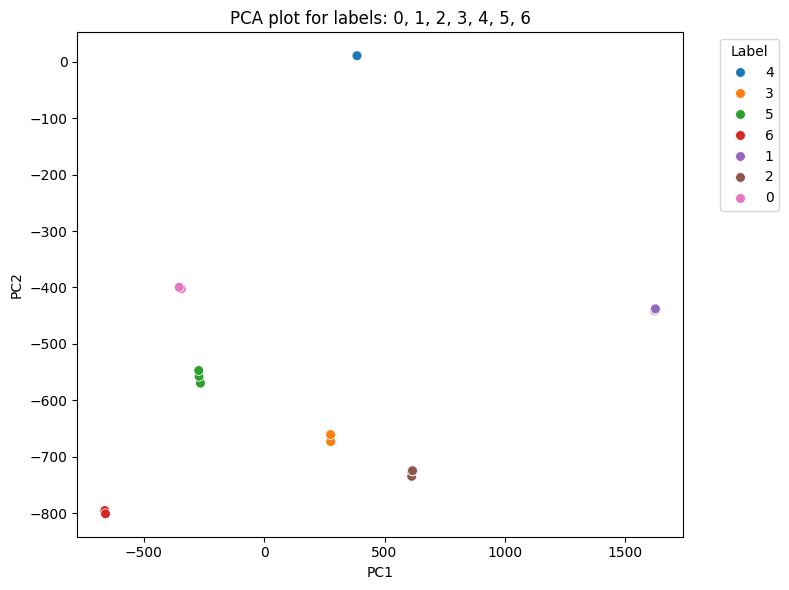

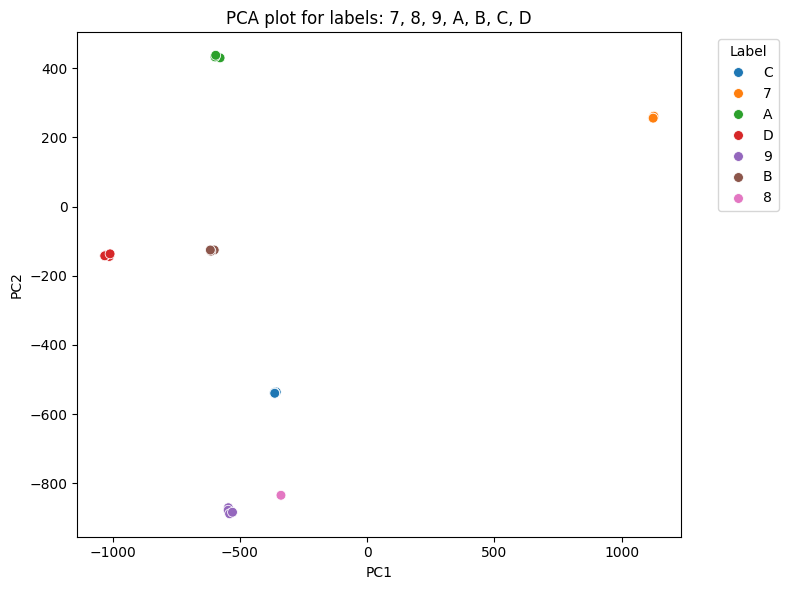

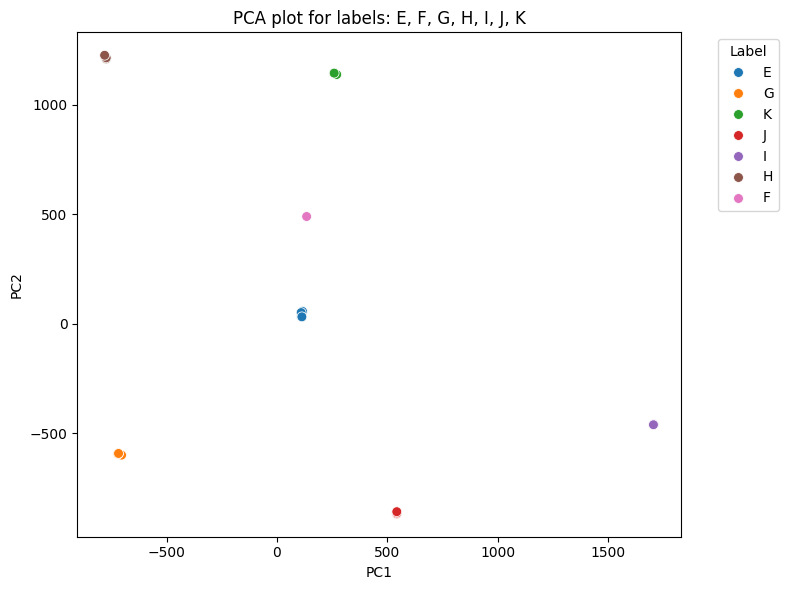

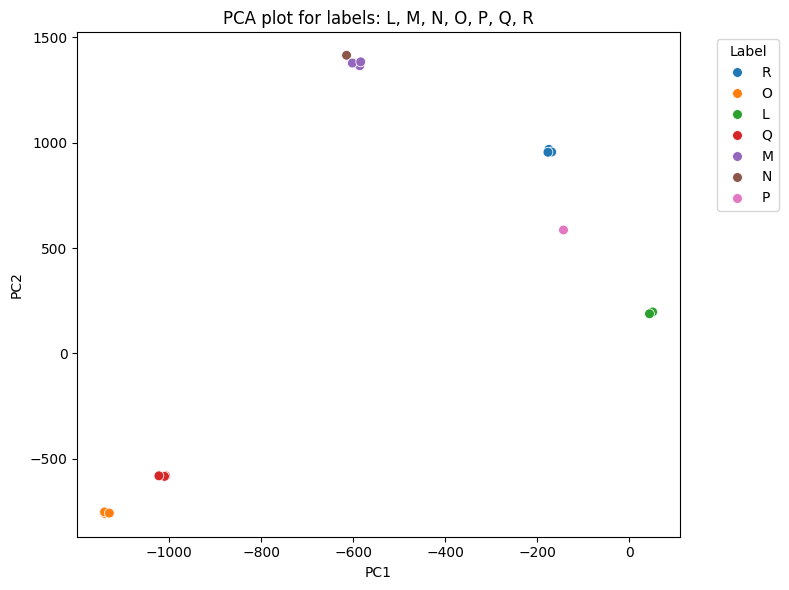

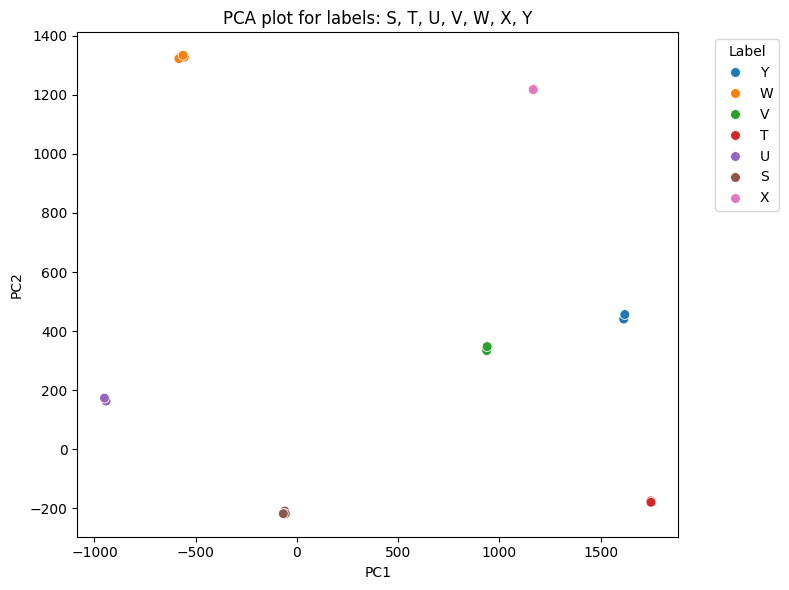

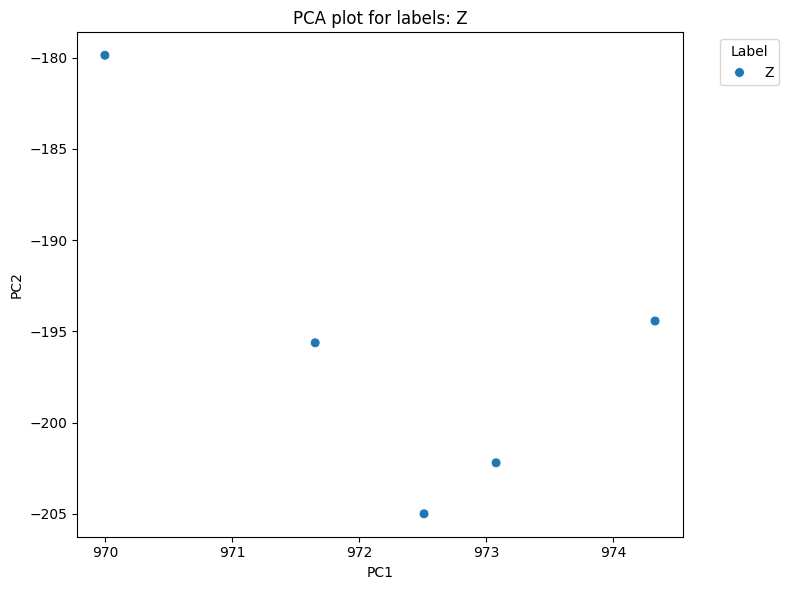

In [9]:
X = df.drop(columns=["label"]).values  # features
y = df["label"].values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for chunk in label_chunks:
    idx = np.isin(y, chunk)
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x=X_pca[idx, 0], y=X_pca[idx, 1],
        hue=y[idx], palette='tab10', s=50
    )
    plt.title(f"PCA plot for labels: {', '.join(chunk)}")
    plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()


## Train Model: Random Forest Classifier for Multi-Class Character Recognition

In [15]:
X_filtered.shape

(120, 240)

In [16]:
y.shape

(120,)

To effectively handle class imbalance, a custom split_and_safe_smote function was designed that first identifies singleton classes with only one sample and excludes them from stratified splitting to avoid errors, since stratification requires each class to appear in both train and test sets. I perform stratified splitting only on classes with sufficient samples to ensure representative distributions, then add the singleton samples exclusively back to the training set, as they cannot be reliably evaluated in testing. Within the training set, classes with fewer than k_neighbors + 1 samples are marked as rare and excluded from SMOTE oversampling to prevent unrealistic synthetic data generation. SMOTE is applied only to common classes with enough samples, dynamically adjusting the k_neighbors parameter to avoid runtime errors and ensure valid neighbor selection. Finally, the SMOTE-resampled common class samples are combined with the untouched rare classes to create a balanced training dataset while preserving rare class integrity. This careful approach balances robust training with realistic testing, improving model generalization and reliability.



In [17]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def split_and_safe_smote(X, y, test_size=0.3, random_state=42, k_neighbors=5):
    """
    Splits the data and applies SMOTE to training data, excluding rare classes
    and handling classes with only 1 sample.

    Returns:
        X_train_resampled, X_test, y_train_resampled, y_test
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(y, np.ndarray):
        y = pd.Series(y)

    # Identify classes with only 1 sample
    value_counts = y.value_counts()
    singleton_classes = value_counts[value_counts == 1].index.tolist()

    # Separate singleton samples
    X_singleton = X[y.isin(singleton_classes)]
    y_singleton = y[y.isin(singleton_classes)]

    # Rest of the data
    X_rest = X[~y.isin(singleton_classes)]
    y_rest = y[~y.isin(singleton_classes)]

    # Stratified split on the rest
    X_train, X_test, y_train, y_test = train_test_split(
        X_rest, y_rest, test_size=test_size, stratify=y_rest, random_state=random_state
    )

    # Add singleton samples to the training set
    X_train = pd.concat([X_train, X_singleton], ignore_index=True)
    y_train = pd.concat([y_train, y_singleton], ignore_index=True)

    # Find rare classes in training set for SMOTE
    train_label_counts = y_train.value_counts()
    rare_classes = train_label_counts[train_label_counts < k_neighbors + 1].index.tolist()

    X_train_common = X_train[~y_train.isin(rare_classes)]
    y_train_common = y_train[~y_train.isin(rare_classes)]

    X_train_rare = X_train[y_train.isin(rare_classes)]
    y_train_rare = y_train[y_train.isin(rare_classes)]

    # Apply SMOTE only if there is enough common samples
    if len(X_train_common) > 0:
        smote = SMOTE(k_neighbors=min(k_neighbors, len(X_train_common)-1), random_state=random_state)
        X_common_resampled, y_common_resampled = smote.fit_resample(X_train_common, y_train_common)

        # Combine back with rare classes
        X_train_resampled = pd.concat([pd.DataFrame(X_common_resampled), X_train_rare], ignore_index=True)
        y_train_resampled = pd.concat([pd.Series(y_common_resampled), y_train_rare], ignore_index=True)
    else:
        print("Warning: No common classes available for SMOTE. Skipping SMOTE.")
        X_train_resampled = X_train.reset_index(drop=True)
        y_train_resampled = y_train.reset_index(drop=True)

    return X_train_resampled, X_test.reset_index(drop=True), y_train_resampled, y_test.reset_index(drop=True)


In [51]:
X_train, X_test, y_train, y_test = split_and_safe_smote(X_filtered, y)


The dataset was split into training and testing sets with a 70:30 ratio to provide ample data for model learning while retaining a sufficient portion for unbiased evaluation. A Random Forest model was chosen because it handles high-dimensional pixel data effectively, is robust to noise, and mitigates overfitting through ensemble averaging. Importantly, Random Forests perform well with imbalanced datasets and can naturally handle multiple classes without requiring extensive preprocessing. These characteristics make it a strong choice for the multi-class CAPTCHA recognition problem with class imbalance. After training on the 70% split, the model’s accuracy and classification metrics were evaluated on the test set to measure its effectiveness in recognizing diverse CAPTCHA characters.

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(85, 240)
(35, 240)
(85,)
(35,)


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Train
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.9428571428571428
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         2
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       0.00     

After training the Random Forest model on the 70% training split and predicting on the 30% test set, multiple evaluation metrics were used to comprehensively assess model performance. Accuracy provides a basic overall correctness measure, but since the dataset contains class imbalance, additional metrics were necessary. The classification report details precision, recall, and F1 scores per class, with zero_division=0 handling rare classes that might have no predicted samples. Weighted F1 score accounts for class imbalance by weighting each class’s F1 by its support, reflecting overall performance more fairly. Macro F1 score treats all classes equally, highlighting performance on minority classes. Balanced accuracy averages recall over all classes, mitigating the bias toward majority classes. Together, these metrics give a robust view of how well the model recognizes both common and rare CAPTCHA characters.

In [31]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    balanced_accuracy_score
)

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report (zero_division=0 to handle rare classes):")
print(classification_report(y_test, y_pred, zero_division=0))

weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
print("Weighted F1 Score:", weighted_f1)

macro_f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print("Macro F1 Score:", macro_f1)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy:", balanced_acc)


Accuracy: 0.9428571428571428

Classification Report (zero_division=0 to handle rare classes):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         2
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.

I optimized the Random Forest model using GridSearchCV to find the best hyperparameters, including the number of trees (n_estimators), tree depth (max_depth), minimum samples to split nodes (min_samples_split), minimum samples per leaf (min_samples_leaf), and the number of features considered at each split (max_features). These choices balance model complexity and overfitting risk while ensuring computational efficiency.

Weighted F1 score was used as the primary tuning metric because it accounts for class imbalance by weighting precision and recall according to class frequency, which is crucial in our multi-class, imbalanced dataset. After tuning with 2-fold cross-validation, the best model was selected and evaluated on the test set using accuracy, weighted F1, and balanced accuracy to comprehensively measure performance across all classes.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, accuracy_score

# Parameter grid to tune
param_grid = {
    'n_estimators': [100, 200],          # number of trees
    'max_depth': [None, 10, 20],         # max tree depth
    'min_samples_split': [2, 5],         # minimum samples to split
    'min_samples_leaf': [1, 2],          # minimum samples at leaf node
    'max_features': ['auto', 'sqrt']     # number of features considered for split
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',  # use weighted F1 for evaluation during tuning
    cv=2,
    n_jobs=-1,
    verbose=2
)

# Run grid search on training data
grid_search.fit(X_train, y_train)

print("Best parameters found:", grid_search.best_params_)

# Best model from grid search
best_rf = grid_search.best_estimator_

# Predict on test set
y_pred = best_rf.predict(X_test)

# Evaluate metrics on test data
acc = accuracy_score(y_test, y_pred)
weighted_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test Weighted F1 Score: {weighted_f1:.4f}")
print(f"Test Balanced Accuracy: {balanced_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  Fi

Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Test Accuracy: 0.9429
Test Weighted F1 Score: 0.9286
Test Balanced Accuracy: 0.9375

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.33      1.00      0.50         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1
           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1

The tuned Random Forest model achieved strong overall performance, with a test accuracy of 94.3%, weighted F1 score of 92.9%, and balanced accuracy of 93.8%, indicating effective handling of class imbalance. Most classes showed perfect precision and recall, reflecting the model’s ability to correctly identify characters across the dataset. However, a few rare classes (e.g., labels ‘1’, ‘I’, and ‘T’) had lower recall and F1 scores due to very limited test samples, highlighting challenges with extremely small class sizes. Despite this, the high weighted and balanced metrics demonstrate that the model generalizes well across the diverse multi-class character set.

In [37]:
import joblib

# Save best final random forest model in a .pkl file
joblib.dump(best_rf, 'random_forest_model.pkl')


['random_forest_model.pkl']

## Model Inference on Unseen Image: input100.jpg

In this section, I test the trained random_forest_model.pkl on a completely new, unseen image (input100.jpg). The goal is to evaluate the model’s generalization ability by predicting character masks and verifying if it can correctly classify and segment characters not encountered during training.

In [47]:
import cv2
import numpy as np
import joblib

# Load model and mask
rf_model = joblib.load('random_forest_model.pkl')
always_white_mask = joblib.load('always_white_mask.pkl')

# Fixed x coordinates per character segment
x_coords = [(5, 13), (14, 22), (23, 31), (32, 40), (41, 49)]

# Load unseen captcha image (grayscale)
img = cv2.imread('/content/drive/My Drive/sampleCaptchas/input/input100.jpg', cv2.IMREAD_GRAYSCALE)

predicted_chars = []

for (x_start, x_end) in x_coords:
    char_img = img[:, x_start:x_end]
    flat_char = char_img.flatten()

    if flat_char.shape[0] != 720:
        flat_char = cv2.resize(char_img, (24, 30)).flatten()

    filtered_char = flat_char[~always_white_mask]

    # Predict
    pred_char = rf_model.predict([filtered_char])[0]
    predicted_chars.append(pred_char)

# Combine predicted letters
captcha_text = ''.join(predicted_chars)
print("Predicted CAPTCHA text:", captcha_text)

Predicted CAPTCHA text: YMB1Q


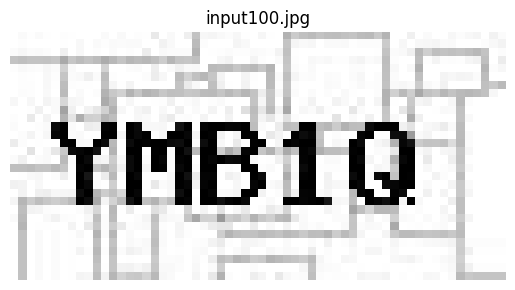

In [52]:
import cv2
import matplotlib.pyplot as plt

# Load image
img = cv2.imread("/content/drive/My Drive/sampleCaptchas/input/input100.jpg")

# Convert to RGB for correct color display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show it
plt.imshow(img_rgb)
plt.axis('off')
plt.title("input100.jpg")
plt.show()


When tested on the unseen image input100.jpg, the model successfully identified and predicted the correct sequence of characters, demonstrating its ability to generalize beyond the training data. This indicates that the pipeline from image preprocessing and character segmentation to classification is functioning as intended. However, to further improve model performance and robustness, especially for underrepresented classes, it is recommended to include more labeled examples in the training dataset. Increasing the diversity of samples can help the model handle variations in character shapes and styles, while also addressing class imbalance to ensure fairer and more accurate predictions across all character types.

## CAPTCHA Inference Pipeline: Predict Characters from Unseen Images (Final Deliverable)

In [18]:
import numpy as np
import joblib
from PIL import Image

class Captcha(object):
    def __init__(self):
        # Load the saved Random Forest model
        self.model = joblib.load("random_forest_model.pkl")

        # Load the always-white mask used during training
        self.always_white_mask = joblib.load("always_white_mask.pkl")

        # Fixed character segmentation coordinates
        self.x_coords = [(5, 13), (14, 22), (23, 31), (32, 40), (41, 49)]

    def load_jpg_image(self, img_path):
        """Load .jpg image and convert it into NumPy array (H, W, 3)."""
        img = Image.open(img_path).convert('RGB')
        return np.array(img)

    def manual_segment(self, img):
        """Segment the image using fixed x-coordinates."""
        return [img[:, x1:x2] for (x1, x2) in self.x_coords]

    def clean_greylines(self, segment, gray_thresh=50, intensity_range=(50, 260)):
        """Remove grayish horizontal artifacts."""
        seg = segment.copy()
        gray = np.abs(seg[:, :, 0] - seg[:, :, 1]) < gray_thresh
        gray &= np.abs(seg[:, :, 1] - seg[:, :, 2]) < gray_thresh
        intensity = seg.mean(axis=2)
        mask = gray & (intensity >= intensity_range[0]) & (intensity <= intensity_range[1])
        seg[mask] = [255, 255, 255]
        return seg

    def flatten_and_filter(self, seg_img):
        """Flatten image and remove always-white columns."""
        flattened = seg_img.flatten()
        filtered = flattened[~self.always_white_mask]
        return filtered

    def __call__(self, im_path, save_path):
        """Perform inference on unseen CAPTCHA image."""
        # Load image
        image = self.load_jpg_image(im_path)

        # Segment into 5 characters
        segments = self.manual_segment(image)

        # Clean gray lines and predict each character
        predicted_text = ""
        for seg in segments:
            cleaned = self.clean_greylines(seg)
            features = self.flatten_and_filter(cleaned)
            prediction = self.model.predict([features])[0]
            predicted_text += prediction

        # Save the predicted string
        with open(save_path, "w") as f:
            f.write(predicted_text)

if __name__ == "__main__":
    captcha_char = Captcha()
    captcha_char("/content/drive/My Drive/sampleCaptchas/input/input100.jpg", "predicted100.txt")
